# Random Walk for Times Series Forecasting

Ref: https://machinelearningmastery.com/gentle-introduction-random-walk-times-series-forecasting-python/

How do you know if your time series problem is predictable?

This is a difficult question with time series forecasting. There is a tool called a **random walk** that can help you understand the predictability of your time series forecast problem.

# Random Series

The Python standard library contains the random module that provides access to a suite of functions for generating random numbers.

The randrange() function can be used to generate a random integer between 0 and an upper limit.

We can use the randrange() function to generate a list of 1,000 random integers between 0 and 10. The example is listed below.

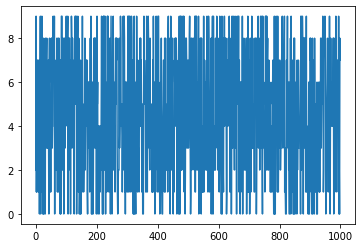

In [6]:
from random import seed
from random import randrange
from matplotlib import pyplot as plt
seed(1)
series = [randrange(10) for i in range(1000)]
plt.plot(series)
plt.show()

It’s a real mess. It looks nothing like a time series. This is **NOT** a random walk. It is just a sequence of random numbers.

A common mistake that beginners make is to think that <span style="color:blue">a random walk is a list of random numbers</span>, and this is **NOT** the case at all.

# Random Walk

**A random walk is different from a list of random numbers** because the next value in the sequence is a modification of the previous value in the sequence.

The process used to generate the series forces dependence from one-time step to the next. This dependence provides some consistency from step-to-step rather than the large jumps that a series of independent, random numbers provides.

It is this dependency that gives the process its name as a “random walk” or a “drunkard’s walk”.

A simple model of a random walk is as follows:

1. Start with a random number of either -1 or 1.

2. Randomly select a -1 or 1 and add it to the observation from the previous time step.

3. Repeat step 2 for as long as you like.

More succinctly, we can describe this process as:

$$y(t) = B_0 + B_1\cdot y(t-1) + \epsilon(t)$$

where $y(t)$ is the next value in the series. $B_0$ is a coefficient that if set to a value other than zero adds a constant drift to the random walk. $B_1$ is a coefficient to weight the previous time step and is set to 1.0. $y(t-1)$ is the observation at the previous time step. $\epsilon(t)$ is the white noise or random fluctuation at that time.

We can implement this in Python by looping over this process and building up a list of 1,000 time steps for the random walk. The complete example is listed below.


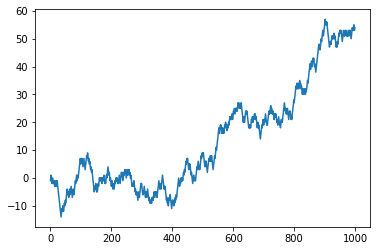

In [7]:
from random import seed
from random import random
from matplotlib import pyplot as plt
seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)
for i in range(1, 1000):
    movement = -1 if random() < 0.5 else 1
    value = random_walk[i-1] + movement
    random_walk.append(value)
plt.plot(random_walk)
plt.show()

In the next sections, we will take a closer look at the properties of a random walk. This is helpful because it will give you context to help identify whether a time series you are analyzing in the future might be a random walk.

Let’s start by looking at the autocorrelation structure.

# Random Walk and Autocorrelation

We can calculate the correlation between each observation and the observations at previous time steps. A plot of these correlations is called an autocorrelation plot or a correlogram.

Given the way that the random walk is constructed, we would expect a strong autocorrelation with the previous observation and a linear fall off from there with previous lag values.

We can use the autocorrelation_plot() function in Pandas to plot the correlogram for the random walk.

The complete example is listed below:

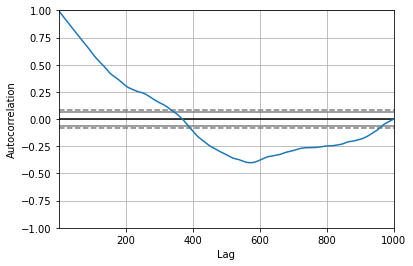

In [8]:
from random import seed
from random import random
from matplotlib import pyplot as plt
from pandas.plotting import autocorrelation_plot
seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)
for i in range(1, 1000):
    movement = -1 if random() < 0.5 else 1
    value = random_walk[i-1] + movement
    random_walk.append(value)
autocorrelation_plot(random_walk)
plt.show()

In [41]:
from scipy.stats import pearsonr
import numpy as np

In [53]:
def calc_autocorrelation(ts, n:int=0):
    if n==0:
        corr = pearsonr(ts[:], ts[:])[0]
    else:
        # corr = pearsonr(ts[:-n], ts[n:])[0]
        corr = np.corrcoef(np.array([ts[:-n], ts[n:]]))[0][1]
    return corr

In [54]:
autocorr = []
for n in range(1000-1): # pearson: x and y must have length at least 2.
    autocorr.append(calc_autocorrelation(random_walk, n=n))

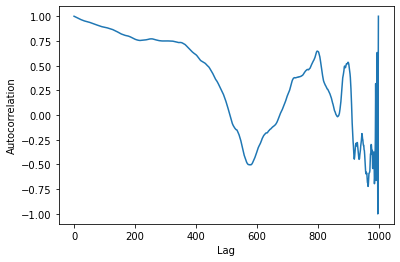

In [55]:
plt.plot(range(len(autocorr)), autocorr)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

In [35]:
np.corrcoef(np.array([random_walk[:-n], random_walk[n:]]))

0.9986183596314077

# Random Walk and Stationarity

**A stationary time series is one where the values are <span style="color:red">not</span> a function of time.**

Given the way that the random walk is constructed and the results of reviewing the autocorrelation, we know that the observations in a random walk are dependent on time.

The current observation is a random step from the previous observation.

Therefore we can expect a random walk to be non-stationary. In fact, <span style="color:blue">**all random walk processes are non-stationary. Note that not all non-stationary time series are random walks.** </span>

Additionally, a non-stationary time series does not have a consistent mean and/or variance over time. A review of the random walk line plot might suggest this to be the case.

We can confirm this using a statistical significance test, specifically the Augmented Dickey-Fuller test.

We can perform this test using the adfuller() function in the statsmodels library. The complete example is listed below.

In [56]:
from random import seed
from random import random
from statsmodels.tsa.stattools import adfuller

# generate random walk
seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)
for i in range(1, 1000):
    movement = -1 if random() < 0.5 else 1
    value = random_walk[i-1] + movement
    random_walk.append(value)
    
# statistical test
result = adfuller(random_walk)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.341605
p-value: 0.979175
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


<span style="color:blue">Null hypothesis H0: $\lambda=0$, and time series is non-stationary.</span> Based on the ADF test above, we can't reject this null hypothesis, and we accept that the time series is non-stationary. 

Running the example, we can see that the test statistic value was 0.341605. This is larger than all of the critical values at the 1%, 5%, and 10% confidence levels. Therefore, we can say that the time series does appear to be **non-stationary** with a low likelihood of the result being a statistical fluke.

We can make the random walk stationary by taking the first difference.

That is replacing each observation as the difference between it and the previous value.

Given the way that this random walk was constructed, we would expect this to result in a time series of -1 and 1 values. This is exactly what we see.

The complete example is listed below.

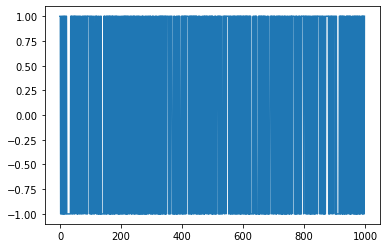

In [58]:
from random import seed
from random import random
from matplotlib import pyplot as plt

# create random walk
seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)
for i in range(1, 1000):
    movement = -1 if random() < 0.5 else 1
    value = random_walk[i-1] + movement
    random_walk.append(value)
    
# take difference
diff = list()
for i in range(1, len(random_walk)):
    value = random_walk[i] - random_walk[i - 1]
    diff.append(value)
    
# line plot
plt.plot(diff)
plt.show()

Running the example produces a line plot showing 999 movements of -1 and 1, a real mess.

This difference graph also makes it clear that really we have no information to work with here other than a series of random moves.

There is no structure to learn.

Now that the time series is stationary, we can recalculate the correlogram of the differenced series. The complete example is listed below.

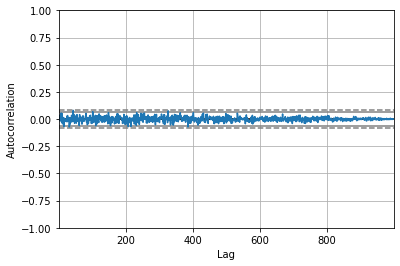

In [61]:
from random import seed
from random import random
from matplotlib import pyplot as plt
from pandas.plotting import autocorrelation_plot

# create random walk
seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)
for i in range(1, 1000):
    movement = -1 if random() < 0.5 else 1
    value = random_walk[i-1] + movement
    random_walk.append(value)
    
# take difference
diff = list()
for i in range(1, len(random_walk)):
    value = random_walk[i] - random_walk[i - 1]
    diff.append(value)
    
# autocorrelation line plot
autocorrelation_plot(diff)
pyplot.show()

Running the example, we can see no significant relationship between the lagged observations, as we would expect from the way the random walk was generated.

All correlations are small, close to zero and below the 95% and 99% confidence levels (beyond a few statistical flukes).

# Predicting a Random Walk

A random walk is unpredictable; it cannot reasonably be predicted.

Given the way that the random walk is constructed, we can expect that the best prediction we could make would be to use the observation at the previous time step as what will happen in the next time step.

Simply because we know that the next time step will be a function of the prior time step.

This is often called the naive forecast, or a persistence model.

We can implement this in Python by first splitting the dataset into train and test sets, then using the persistence model to predict the outcome using a rolling forecast method. Once all predictions are collected for the test set, the mean squared error is calculated.

In [63]:
from random import random
from sklearn.metrics import mean_squared_error

# generate the random walk
seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)
for i in range(1, 1000):
    movement = -1 if random() < 0.5 else 1
    value = random_walk[i-1] + movement
    random_walk.append(value)
    
# prepare dataset
train_size = int(len(random_walk) * 0.66)
train, test = random_walk[0:train_size], random_walk[train_size:]

# persistence
predictions = list()
history = train[-1]
for i in range(len(test)):
    yhat = history
    predictions.append(yhat)
    history = test[i]
error = mean_squared_error(test, predictions)
print('Persistence MSE: %.3f' % error)

Persistence MSE: 1.000


Running the example estimates the mean squared error of the model as 1.

This too is expected, given that we know that the variation from one time step to the next is always going to be 1, either in the positive or negative direction, and the square of this expected error is 1 ($1^2 = (-1)^2 = 1$).

Another error that beginners to the random walk make is to assume that if the range of error (variance) is known, then we can make predictions using a random walk generation type process.

That is, if we know the error is either -1 or 1, then why not make predictions by adding a randomly selected -1 or 1 to the previous value.

We can demonstrate this random prediction method in Python below.

In [65]:
from random import seed
from random import random
from sklearn.metrics import mean_squared_error

# generate the random walk
seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)
for i in range(1, 1000):
    movement = -1 if random() < 0.5 else 1
    value = random_walk[i-1] + movement
    random_walk.append(value)
    
# prepare dataset
train_size = int(len(random_walk) * 0.66)
train, test = random_walk[0:train_size], random_walk[train_size:]

# random prediction
predictions = list()
history = train[-1]
for i in range(len(test)):
    yhat = history + (-1 if random() < 0.5 else 1)
    predictions.append(yhat)
    history = test[i]
error = mean_squared_error(test, predictions)
print('Random MSE: %.3f' % error)

Random MSE: 1.765


Running the example, we can see that indeed the algorithm results in a worse performance than the persistence method, with a mean squared error of 1.765.

Therefore, <span style="color:blue"> **Persistence, or the naive forecast, is the best prediction we can make for a random walk time series.**</span>

# Is Your Time Series a Random Walk?

Your time series may be a random walk.

Some ways to check if your time series is a random walk are as follows:

- The time series shows a strong temporal dependence that decays linearly or in a similar pattern.

- The time series is non-stationary and making it stationary shows no obviously learnable structure in the data.

- The persistence model provides the best source of reliable predictions.

This last point is key for time series forecasting. Baseline forecasts with the persistence model quickly flesh out whether you can do significantly better. If you can’t, you’re probably working with a random walk.

Many time series are random walks, particularly those of security prices over time.

The random walk hypothesis is a theory that stock market prices are a random walk and cannot be predicted.

A random walk is one in which future steps or directions cannot be predicted on the basis of past history. When the term is applied to the stock market, it means that short-run changes in stock prices are unpredictable.

— Page 26, A Random Walk down Wall Street: The Time-tested Strategy for Successful Investing

The human mind sees patterns everywhere and we must be vigilant that we are not fooling ourselves and wasting time by developing elaborate models for random walk processes.